In [1]:
import itertools
import warnings
import time

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.special

# The MCMC Hammer
import emcee

# BE/Bi 103 utilities
import bebi103

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner
import numdifftools as ndt

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv("./data/gardner_hw6/gardner_mt_catastrophe_only_tubulin.csv", comment="#")

In [3]:
df.head()

,12 uM,7 uM,9 uM,10 uM,14 uM
0,25.000,35,25,50,60
1,40.000,45,40,60,75
2,40.000,50,40,60,75
3,45.429,50,45,75,85
4,50.000,55,50,75,115


In [4]:

def log_likelihood(tau, t, m):
    """
    Takes in tau (should be an array of length m), 
    data (Pandas data series), various values for m. 
    We are very proud of this function.
    """   
    # set up array to store the log likelihoods calculated for each
    # value of t
    log_like = np.empty((len(t), 1))
    
    num_handler = np.empty((len(t), m)) # the numerator of the scaling factor
    exp_handler = np.empty((len(t), m)) # the exponent part of the numerators
    den_elem = np.empty(m) # temporary array to store elements of the denominator 
                           # of the scaling factor
    den_handler = np.empty((len(t), m)) # denominator of the scaling factor
    
    # iterate over j for all data points 
    for j in range(m):
        num_handler[:,j] = tau[j]**(m-2)
        exp_handler[:,j] = -t/tau[j]
        den_elem = tau[j] - tau
        # use only non-zero elements when taking the product 
        # in the denominator of the scaling factor 
        den_prod = np.prod(den_elem[:j]) * np.prod(den_elem[j+1:])
        den_handler[:,j] = den_prod 
        den_elem = np.empty(m)

    scaling_factor = num_handler / den_handler

    # store the log likelihoods in an array 
    log_like = scipy.misc.logsumexp(exp_handler, axis=1, b=scaling_factor)            

    # return the sum of the log likelihoods
    return np.sum(log_like)

def log_prior(tau, m, tau_min, tau_max):
    """
    Log prior for model defined above. Takes in m and tau, 
    returns log prior.
    """
    # check that tau is ordered least to greatest
    for i in range(m-1):
        if not (tau[i] + 1.0) < tau[i+1]:
            return -np.inf
    
    # check that tau is not outside the boundaries we define
    if tau[0] < tau_min or tau[-1] > tau_max:
        return -np.inf
    
    prior = np.empty(m)
    # calculate and store the elements of the normalized prior 
    # associated with each tau 
    for i in range(m):
        if m == 1:
            prior[i] = tau[i] * np.log(tau_max / tau_min)
        
        elif m > 1 and i == 0:
            prior[i] = tau[i] * np.log(tau[i+1] / tau_min)
        
        elif m > 1 and i == m-1:
            prior[i] = tau[i] * np.log(tau_max / tau[i-1])
        
        else:
            prior[i] = tau[i] * np.log(tau[i+1] / tau[i-1])
            
    return -np.log(np.prod(prior))
        
def tau_start(m, n_walkers, n_temps):
    """
    Generates starting points for each tau.
    """
    p = np.empty((n_temps, n_walkers, m))
    
    for i in range(m):
        p[:,:,i] = np.random.exponential(300, (n_temps,n_walkers))
    return p

In [250]:
def sample_ptmcmc(data, m, model, tau_min=1, tau_max=1800, n_temps=20, n_walkers=100, n_burn=100, 
                  n_steps=500, threads=None):
    
    # arguments for likelihood
    loglargs = (data, m)
    
    # arguments for prior
    logpargs = (m, tau_min, tau_max)
    
    # starting points for the parameters
    p0 = tau_start(m, n_walkers, n_temps)
    
    # column headings for outputted DataFrames
    columns = {'m = 1': ['tau_1'],
               'm = 2': ['tau_1', 'tau_2'],
               'm = 3': ['tau_1', 'tau_2', 'tau_3'],
               'm = 4': ['tau_1', 'tau_2', 'tau_3', 'tau_4'],
               'm = 5': ['tau_1', 'tau_2', 'tau_3', 'tau_4', 'tau_5']}
    
    return bebi103.run_pt_emcee(
            log_likelihood, log_prior, n_burn, n_steps,
            n_temps=n_temps, p0=p0, loglargs=loglargs, logpargs=logpargs, 
            threads=threads, columns=columns[model], return_lnZ=True)

In [251]:
start = time.time()
df_3, lnZ_3, dlnZ_3 = sample_ptmcmc(df['12 uM'], 3, 'm = 3', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=1000, n_steps=5000, threads=3)
print('The third PTMCMC took ', time.time()-start, ' seconds.')



The third PTMCMC took  992.8402371406555  seconds.


In [6]:
start = time.time()
df_1, lnZ_1, dlnZ_1 = sample_ptmcmc(df['12 uM'], 1, 'm = 1', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=1000, n_steps=5000, threads=3)
print('The first PTMCMC took ', time.time()-start, ' seconds.')

start = time.time()
df_2, lnZ_2, dlnZ_2 = sample_ptmcmc(df['12 uM'], 2, 'm = 2', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=1000, n_steps=5000, threads=3)
print('The second PTMCMC took ', time.time()-start, ' seconds.')

start = time.time()
df_3, lnZ_3, dlnZ_3 = sample_ptmcmc(df['12 uM'], 3, 'm = 3', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=1000, n_steps=5000, threads=3)
print('The third PTMCMC took ', time.time()-start, ' seconds.')

start = time.time()
df_4, lnZ_4, dlnZ_4 = sample_ptmcmc(df['12 uM'], 4, 'm = 4', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=1000, n_steps=5000, threads=3)
print('The fourth PTMCMC took ', time.time()-start, ' seconds.')

start = time.time()
df_5, lnZ_5, dlnZ_5 = sample_ptmcmc(df['12 uM'], 5, 'm = 5', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=1000, n_steps=5000, threads=3)
print('The fifth PTMCMC took ', time.time()-start, ' seconds.')

The first PTMCMC took  1116.4163601398468  seconds.
The second PTMCMC took  1351.2568359375  seconds.
The third PTMCMC took  1094.7742569446564  seconds.
The fourth PTMCMC took  1206.7325630187988  seconds.
The fifth PTMCMC took  843.8138411045074  seconds.


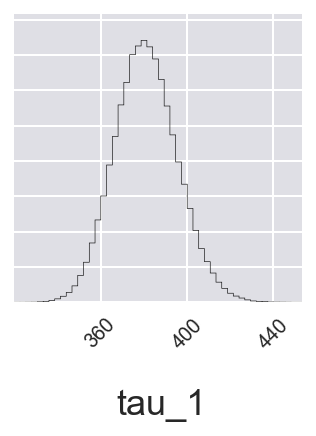

In [16]:
_ = corner.corner(df_1[df_1.beta_ind==0][['tau_1']], bins=50)

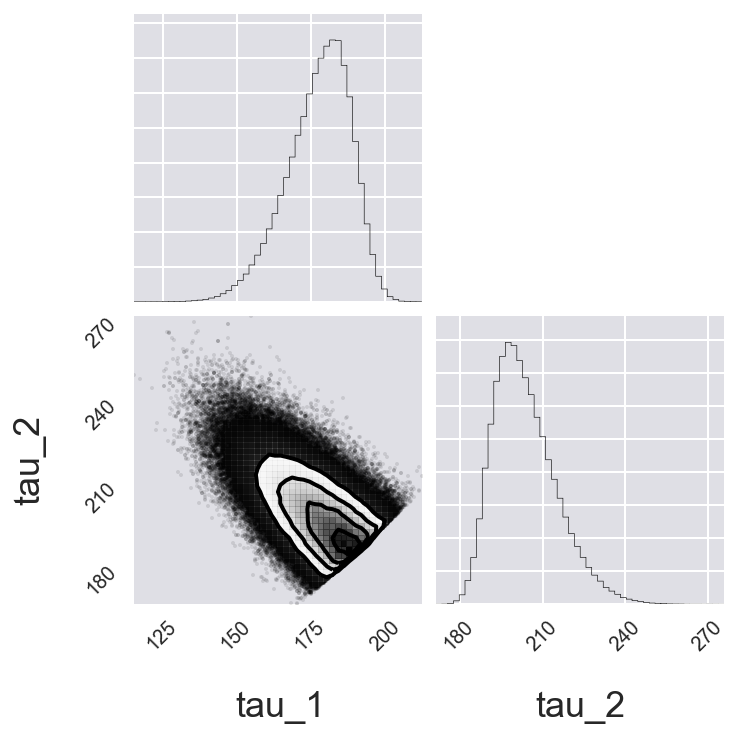

In [15]:
_ = corner.corner(df_2[df_2.beta_ind==0][['tau_1', 'tau_2']], bins=50)

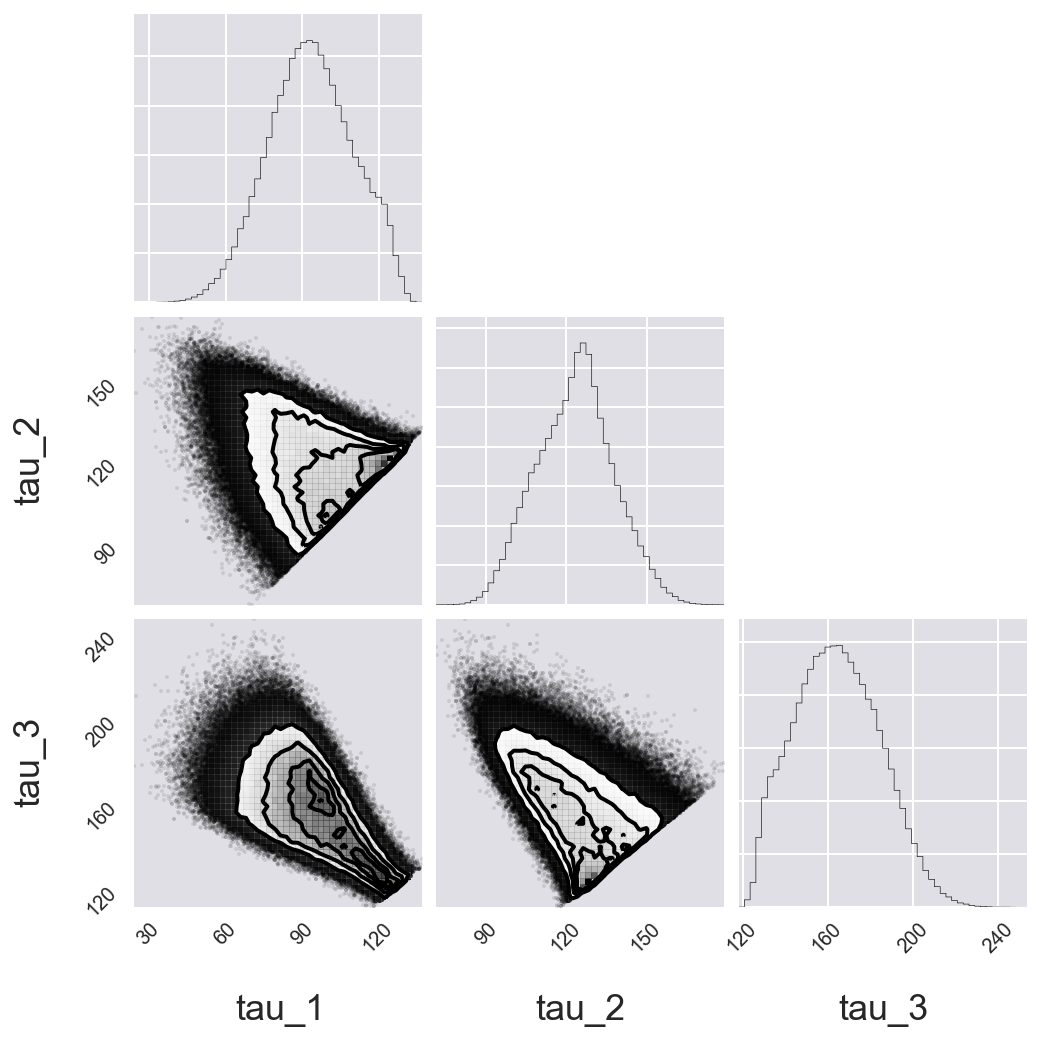

In [18]:
_ = corner.corner(df_3[df_3.beta_ind==0][['tau_1', 'tau_2', 'tau_3']], bins=50)

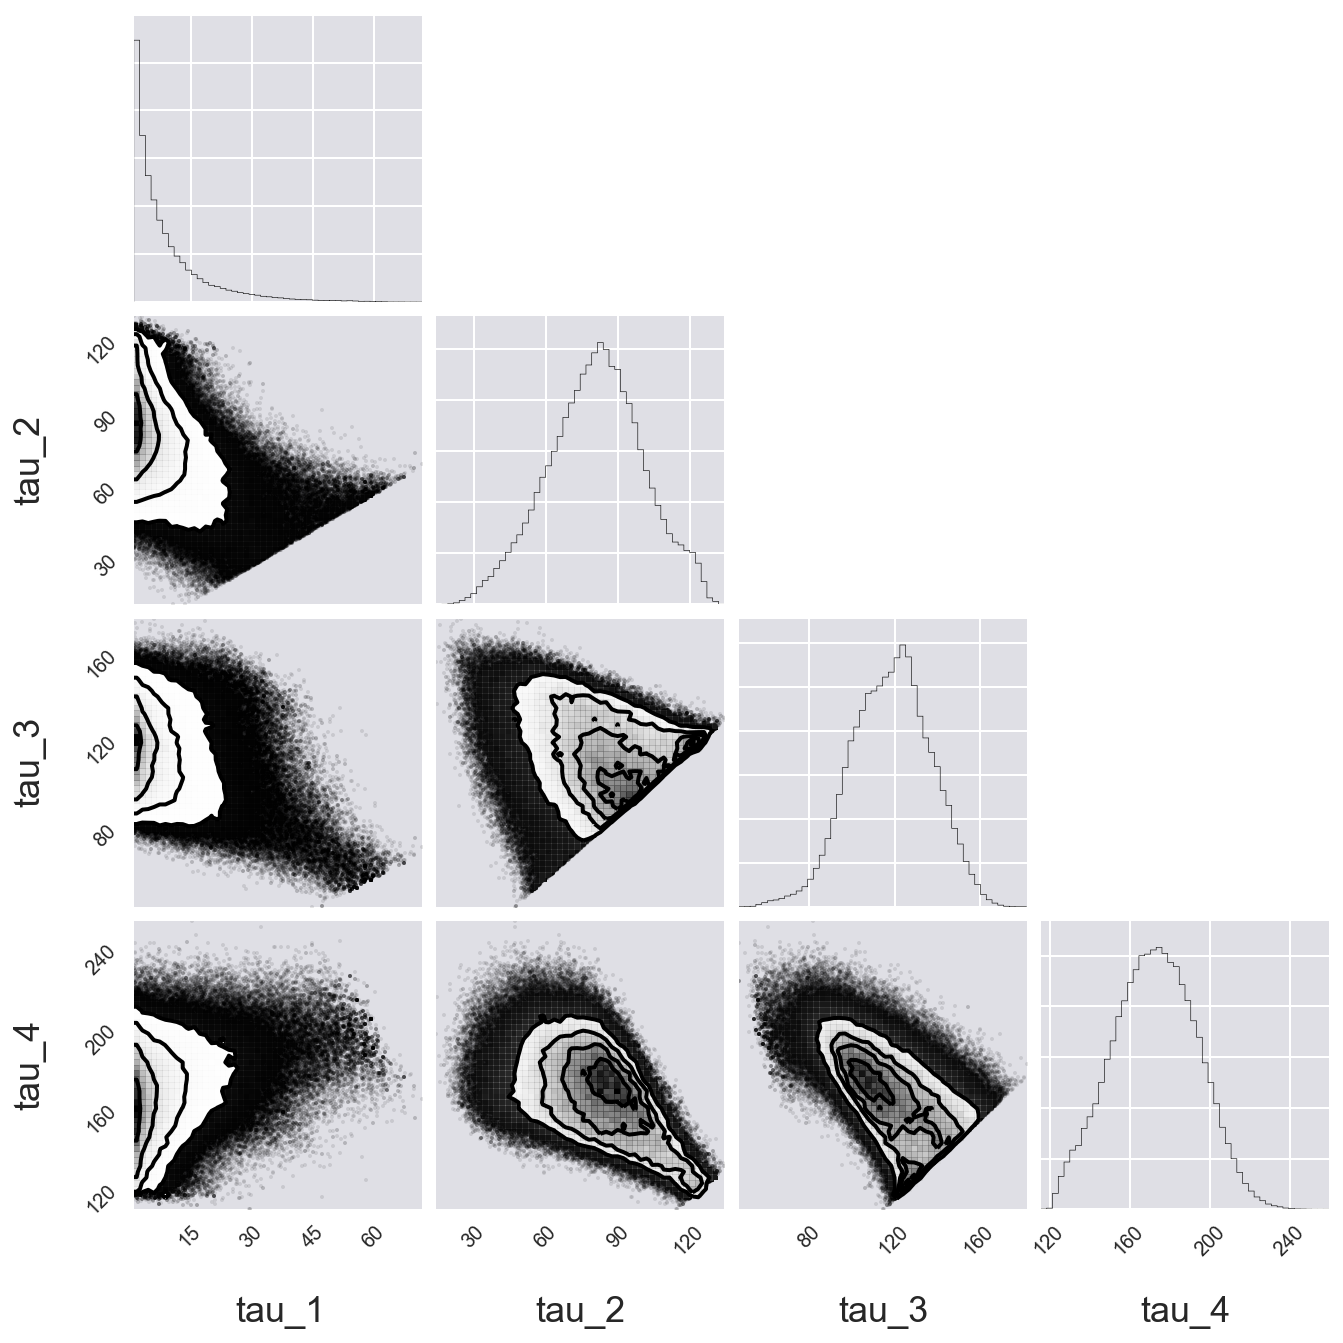

In [19]:
_ = corner.corner(df_4[df_4.beta_ind==0][['tau_1', 'tau_2', 'tau_3', 'tau_4']], bins=50)

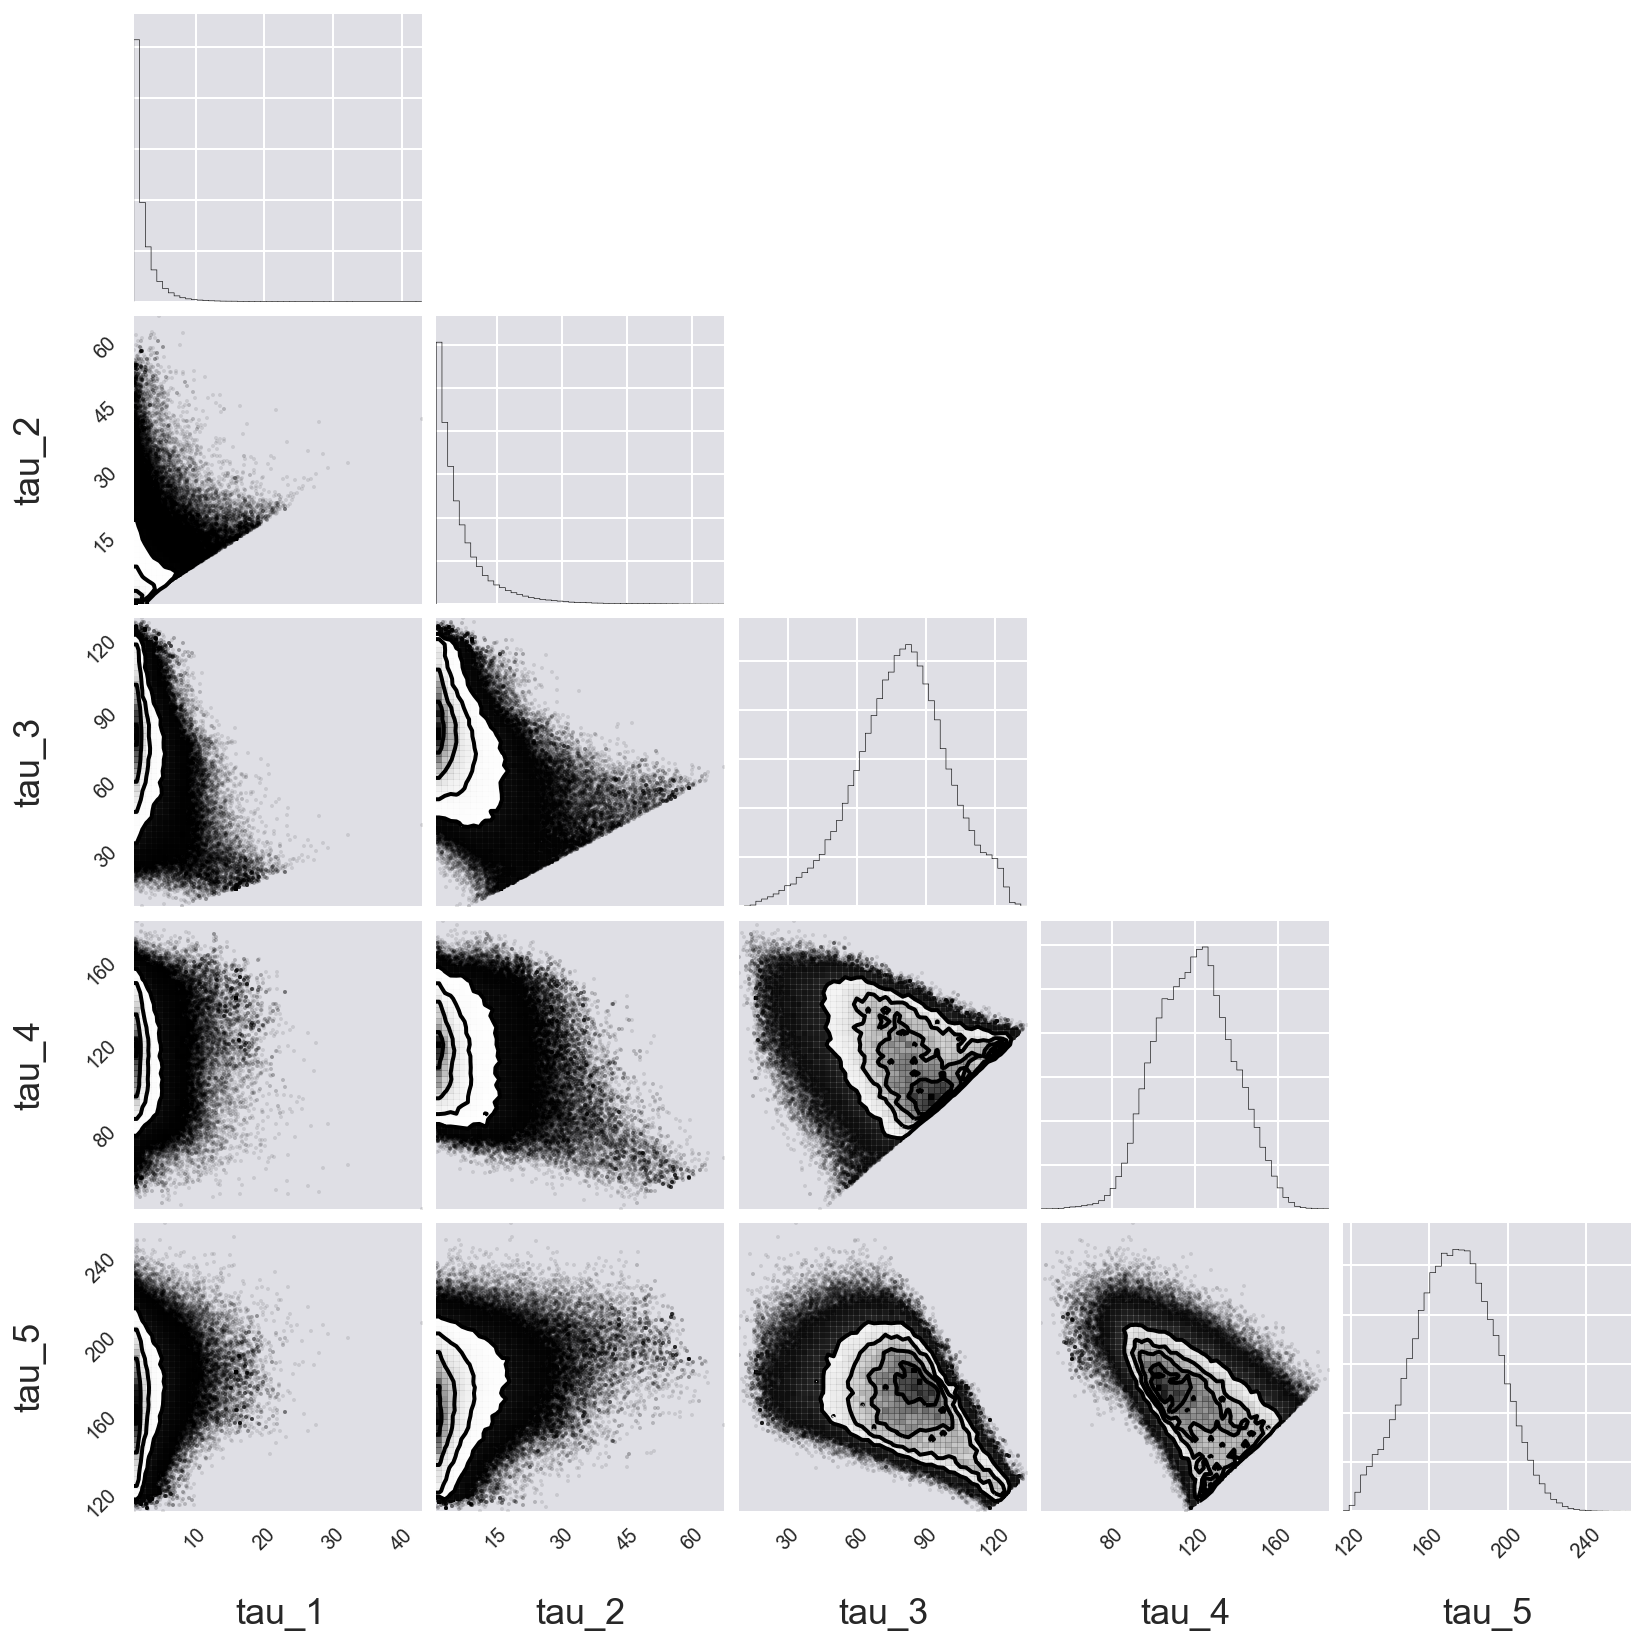

In [29]:
_ = corner.corner(df_5[df_5.beta_ind==0][['tau_1', 'tau_2', 'tau_3', 'tau_4', 'tau_5']], bins=50)

We next wanted to calculate the odds ratios for our models. However, `lnZ` for each of our models was returned as `-inf`. In the course of troubleshooting this issue, one of the first things we did was take a look at the end of the PTMCMC `DataFrame` for one of our models.

In [173]:
df_3.tail()

,tau_1,tau_2,tau_3,lnlike,lnprob,beta_ind,beta,chain
9999995,333.761096,717.872141,106.26238,-inf,NaN,19,4.314151e-13,99
9999996,333.761096,717.872141,106.26238,-inf,NaN,19,4.314151e-13,99
9999997,333.761096,717.872141,106.26238,-inf,NaN,19,4.314151e-13,99
9999998,333.761096,717.872141,106.26238,-inf,NaN,19,4.314151e-13,99
9999999,333.761096,717.872141,106.26238,-inf,NaN,19,4.314151e-13,99


This was very strange to us: we should not be getting `-inf` for any of our log likelihoods. Moreover, we found that more than half of our samples had this issue: 

In [181]:
print("""Percentage of samples with lnlike = -inf: {0:.2f}%
""".format(100 - (len(df_3[df_3.lnlike != -np.inf]) / len(df_3) * 100)))

Percentage of samples with lnlike = -inf: 55.78%



We double- and triple-checked our log likelihood function and could not see a situation in which it would return `-inf`. In fact, running our `log_likelihood` function with the values of `tau_1`, `tau_2`, and `tau_3` recorded for the last sample (for which `lnlike` was reported as `-inf`), we got a finite value:

In [174]:
log_likelihood(np.array([333.761096, 717.872141, 106.26238]), df['12 uM'], 3)

-5355.1717501076555

However, we note that our values of $\tau_j$ are not in proper ranked order for those samples that have `lnlike = -inf`. (This appeared to be generally true, although above we only show the end of the `DataFrame` as an example.) This was again surprising to us because we had thought `emcee` would not record samples for which the prior was evaluated as `-inf`. Just to double-check our prior, we ran our `log_prior` function with the same values of `tau` we tested in the `log_likelihood` function above, and as expected, we got `-inf`. This prompted us to look at the [source code](https://github.com/dfm/emcee/blob/master/emcee/ptsampler.py) for the PT sampler in `emcee`. We discovered in lines 90-94 that in the case of the log prior returning `-inf`, `emcee` records both the log likelihood and the log prior as `-inf` (it does not actually evaluate the log likelihood function in this case - which indeed it shouldn't). Then, reading carefully lines 252-270 and 318-362, we found that when `emcee` evaluates whether to accept a step, it definitely rejects the step if the log prior is `-inf`; however, unless we are misinterpreting the code, it seems that the log likelihood for that sample would also still be recorded as `-inf`. 

At this point, we began to think that we might need to just drop all of the samples with `lnlike = -inf` from our PTMCMC `DataFrame` before calculating `lnZ`, since those samples should have been rejected anyway. First, we confirmed that dropping those samples has no effect on our posterior distribution:

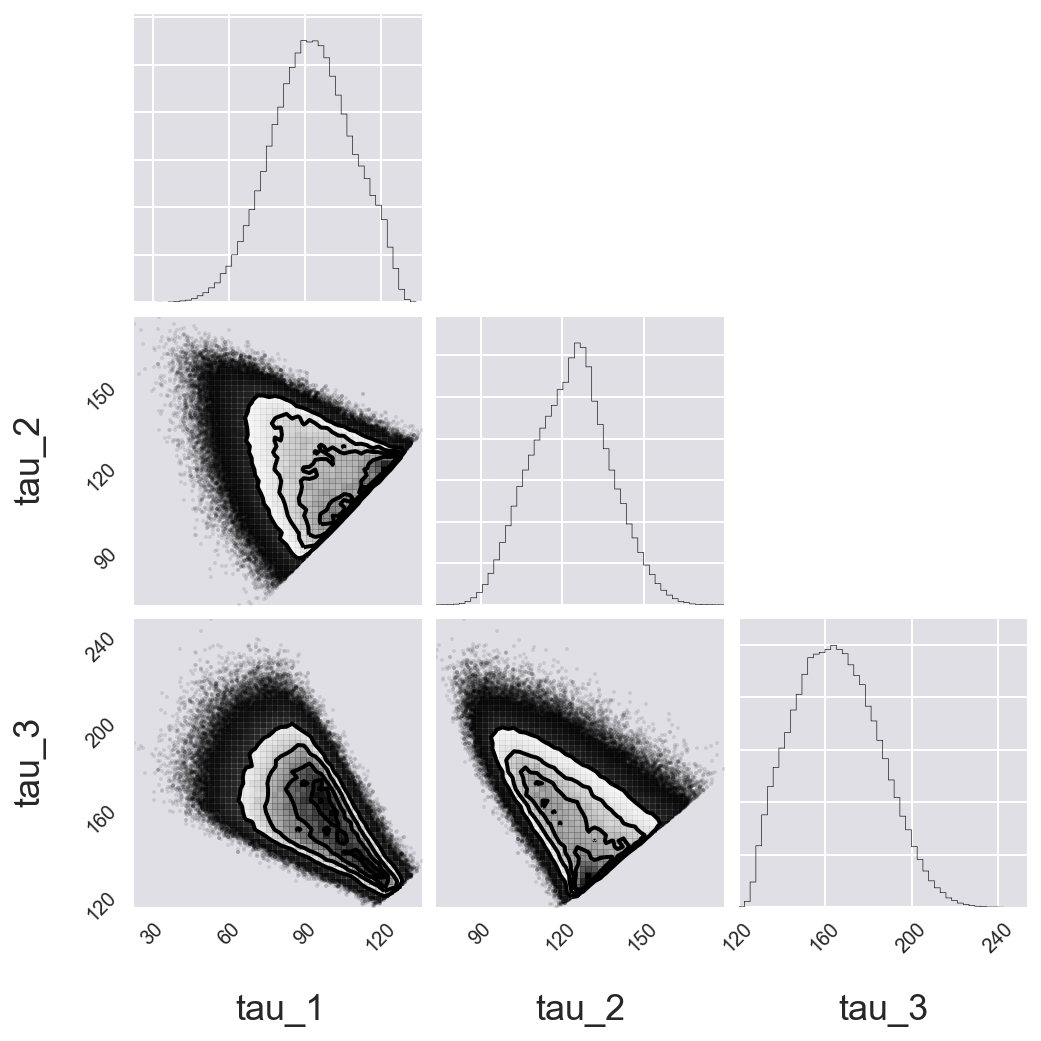

In [253]:
_ = corner.corner(df_3[(df_3.beta_ind==0) & (df_3.lnlike != -np.inf)][['tau_1', 'tau_2', 'tau_3']], bins=50)

So then for each model, we took the `DataFrame` without the problematic samples and calculated `lnZ` using Justin's handy function that was posted on Piazza.

In [182]:
df1_no_inf = df_1[df_1['lnlike'] != -np.inf]
df2_no_inf = df_2[df_2['lnlike'] != -np.inf]
df3_no_inf = df_3[df_3['lnlike'] != -np.inf]
df4_no_inf = df_4[df_4['lnlike'] != -np.inf]
df5_no_inf = df_5[df_5['lnlike'] != -np.inf]

def lnZ(df_mcmc):
    """
    Compute log Z(1) from PTMCMC traces stored in DataFrame.
    """
    # Average the log likelihood over the samples
    log_mean = np.zeros(len(df_mcmc['beta_ind'].unique()))
    for i, b in enumerate(df_mcmc['beta_ind'].unique()):
        log_mean[i] = df_mcmc['lnlike'][df_mcmc['beta_ind']==b].mean()

    # Set of betas (temperatures)
    betas = np.concatenate((np.array(df_mcmc['beta'].unique()), (0,)))

    # Approximate quadrature
    return -np.dot(log_mean, np.diff(betas))

lnz1 = lnZ(df1_no_inf)
lnz2 = lnZ(df2_no_inf)
lnz3 = lnZ(df3_no_inf)
lnz4 = lnZ(df4_no_inf)
lnz5 = lnZ(df5_no_inf)

Now we can calculate odds ratios.

In [186]:
print('Odds ratio for m = 1 vs m = 2:', np.exp(lnz1 - lnz2))
print('Odds ratio for m = 2 vs m = 3:', np.exp(lnz2 - lnz3))
print('Odds ratio for m = 3 vs m = 4:', np.exp(lnz3 - lnz4))

Odds ratio for m = 1 vs m = 2: 1.87662293233e-61
Odds ratio for m = 2 vs m = 3: 1.48987601545e-11
Odds ratio for m = 3 vs m = 4: 2.0385781172


So far it looks like $m = 3$ gives the best model. Just to double-check, let's calculate the odds ratio for $m = 3$ vs $m = 5$. 

In [187]:
print('Odds ratio for m = 3 vs m = 5:', np.exp(lnz3 - lnz5))

Odds ratio for m = 3 vs m = 5: 6249.25832952


In [252]:
# Get the index of the most probable parameter set
df3_map = df_3[(df_3.beta_ind==0) & (df_3.lnlike != -np.inf)]
max_ind = np.argmax(df3_map.lnprob.values)

# Pull out values.
tau1_MAP, tau2_MAP, tau3_MAP = df3_map.values[max_ind, :3]

# Print the results
print("""
Most probable parameter values:
tau_1:  {0:.3f}
tau_2: {1:.3f}
tau_3: {2:.3f}
""".format(tau1_MAP, tau2_MAP, tau3_MAP))


Most probable parameter values:
tau_1:  126.557
tau_2: 127.586
tau_3: 128.799



In [229]:
df3_map.loc['diff'] = (df3_map['tau_1'] - 90)**2 + (df3_map['tau_2'] - 123)**2 + (df3_map['tau_3'] - 160)**2

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [233]:
df3_map.sort(columns=['diff'], ascending=True).head()

,tau_1,tau_2,tau_3,lnlike,lnprob,beta_ind,beta,chain,diff,new
6958,89.783882,123.027771,159.843954,-4636.931555,-4653.323479,0,1,1,0.071829,0.071829
6959,89.783882,123.027771,159.843954,-4636.931555,-4653.323479,0,1,1,0.071829,0.071829
113927,90.432300,123.009940,160.203823,-4636.828075,-4653.220709,0,1,22,0.228526,0.228526
87605,90.159033,122.600057,160.281614,-4636.882367,-4653.275794,0,1,17,0.264553,0.264553
127973,90.332673,122.941147,160.455897,-4636.816184,-4653.213486,0,1,25,0.321977,0.321977


In [234]:
df3_map.sort(columns=['lnprob'], ascending=False).head()


,tau_1,tau_2,tau_3,lnlike,lnprob,beta_ind,beta,chain,diff,new
489928,129.51967,129.529716,129.532941,-4637.783177,-4645.738263,0,1,97,2532.68318,2532.68318
294964,129.51967,129.529716,129.532941,-4637.783177,-4645.738263,0,1,58,2532.68318,2532.68318
349934,129.51967,129.529716,129.532941,-4637.783177,-4645.738263,0,1,69,2532.68318,2532.68318
294999,129.51967,129.529716,129.532941,-4637.783177,-4645.738263,0,1,58,2532.68318,2532.68318
304978,129.51967,129.529716,129.532941,-4637.783177,-4645.738263,0,1,60,2532.68318,2532.68318


In [258]:
df3_map.sort(columns=['lnlike'], ascending=False).head()



,tau_1,tau_2,tau_3,lnlike,lnprob,beta_ind,beta,chain
305429,100.341815,101.473658,178.871909,-4636.220701,-4652.674385,0,1,61
75425,100.502914,101.632033,178.259005,-4636.220725,-4652.665184,0,1,15
75426,100.502914,101.632033,178.259005,-4636.220725,-4652.665184,0,1,15
75424,100.502914,101.632033,178.259005,-4636.220725,-4652.665184,0,1,15
305428,100.502914,101.632033,178.259005,-4636.220725,-4652.665184,0,1,61


In [257]:
tau1_map = df3_map['tau_1'].median()
tau2_map = df3_map['tau_2'].median()
tau3_map = df3_map['tau_3'].median()
tau_map = np.array([tau1_map, tau2_map, tau3_map])

In [264]:
df_1.to_csv('/Users/elenaperry/Desktop/df1.csv')
df_2.to_csv('/Users/elenaperry/Desktop/df2.csv')
df_3.to_csv('/Users/elenaperry/Desktop/df3.csv')
df_4.to_csv('/Users/elenaperry/Desktop/df4.csv')
df_5.to_csv('/Users/elenaperry/Desktop/df5.csv')

In [5]:
def log_likelihood(tau, t, m):
    """
    Takes in tau (should be an array of length m), 
    data (Pandas data series), various values for m. 
    We are very proud of this function.
    """   
    # set up array to store the log likelihoods calculated for each
    # value of t
    log_like = np.empty((len(t), 1))
    
    num_handler = np.empty((len(t), m)) # the numerator of the scaling factor
    exp_handler = np.empty((len(t), m)) # the exponent part of the numerators
    den_elem = np.empty(m) # temporary array to store elements of the denominator 
                           # of the scaling factor
    den_handler = np.empty((len(t), m)) # denominator of the scaling factor
    
    # iterate over j for all data points 
    for j in range(m):
        num_handler[:,j] = tau[j]**(m-2)
        exp_handler[:,j] = -t/tau[j]
        den_elem = tau[j] - tau
        # use only non-zero elements when taking the product 
        # in the denominator of the scaling factor 
        den_prod = np.prod(den_elem[:j]) * np.prod(den_elem[j+1:])
        den_handler[:,j] = den_prod 
        den_elem = np.empty(m)

    scaling_factor = num_handler / den_handler

    # store the log likelihoods in an array 
    log_like = scipy.misc.logsumexp(exp_handler, axis=1, b=scaling_factor)            

    # return the sum of the log likelihoods
    return np.sum(log_like)

def log_prior(tau, m, tau_min, tau_max):
    """
    Log prior for model defined above. Takes in m and tau, 
    returns log prior.
    """
    # check that tau is ordered least to greatest
    for i in range(m-1):
        if not (tau[i] + 1.0) < tau[i+1]:
            return -np.inf
    
    # check that tau is not outside the boundaries we define
    if tau[0] < tau_min or tau[-1] > tau_max:
        return -np.inf
    
    prior = np.empty(m)
    # calculate and store the elements of the normalized prior 
    # associated with each tau 
    for i in range(m):
        if m == 1:
            prior[i] = tau[i] * np.log(tau_max / tau_min)
        
        elif m > 1 and i == 0:
            prior[i] = tau[i] * np.log(tau[i+1] / tau_min)
        
        elif m > 1 and i == m-1:
            prior[i] = tau[i] * np.log(tau_max / tau[i-1])
        
        else:
            prior[i] = tau[i] * np.log(tau[i+1] / tau[i-1])
            
    return -np.log(np.prod(prior))



In [18]:
def log_post(p, t, tau_min=1, tau_max=1800):
    
    tau_1, tau_2, tau_3 = p
    
    if not (tau_1 + 1e-6) < tau_2 and (tau_2 +1e6) < tau_3:
        return -np.inf
    
    if not (tau_1 > tau_min) and (tau_3 < tau_max):
        return -np.inf

    return log_likelihood(p, t, 3) + log_prior(p, 3, tau_min=1, tau_max=1800)

def negative_log_post(p, t, tau_min=1, tau_max=1800):
    
    return -log_post(p, t, tau_min, tau_max)

t = df["12 uM"]
#m=3
args = (t,)

p0 = (130,200,300)
hes_fun = ndt.Hessian(log_post)
res = scipy.optimize.minimize(negative_log_post, p0, args=args)
hes = hes_fun(res.x,t)
cov = -np.linalg.inv(hes)


//anaconda/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:739: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
//anaconda/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
//anaconda/lib/python3.4/site-packages/numdifftools/core.py:610: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


In [19]:
res.x

array([ 106.54655576,  107.54714353,  166.16425278])

In [20]:
df_7um = []


In [22]:
df

,12 uM,7 uM,9 uM,10 uM,14 uM
0,25.000,35,25,50,60
1,40.000,45,40,60,75
2,40.000,50,40,60,75
3,45.429,50,45,75,85
4,50.000,55,50,75,115
5,55.000,55,50,85,115
6,56.386,55,55,90,135
7,60.000,55,55,90,140
8,60.000,55,60,100,145
9,60.000,60,65,105,150


In [27]:
len(df["12 uM"].dropna().unique())

334

In [28]:
a=["True"]
np.nonzero(a)

(array([0]),)